# Support Vector Regressor
Haytham Mohamed

INFS 890 - Spring 2020

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVR
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import seaborn as sns
from sklearn import preprocessing, metrics, feature_selection
from datetime import datetime
from scipy import stats
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

sns.set()
sns.set(color_codes=True)
#sns.set_color_codes()

pd.options.display.max_rows = 15
pd.options.display.float_format = '{:,.2f}'.format

Set this flag to True if you're using reduction feature using FCA, otherwise set it to False

In [58]:
# 1- read data file
# 1- read processed file
home_dir = '/Users/hmohamed/github/data-research-spring2020/sock-shop'
file_dir = home_dir + '/processed-data/'



#data_file = 'order_flow_cleanup_data.csv'
data_file = 'order_flow_normalized_data.csv'
#data_file = 'order_flow_standardized_data.csv'
#data_file = 'order_flow_factored_data.csv'


test_split = 0.1


In [59]:
def read_df(file_dir, data_file, timeseries=True):
    df = pd.read_csv(file_dir + data_file)
    if timeseries:
        df = to_time_series(df)
    return df

def to_time_series(df, index_col_name='date'):
    df[index_col_name] = pd.to_datetime(df[index_col_name])
    df.set_index(index_col_name, inplace=True)
    df.sort_index(inplace=True)
    return df

def merge(df, series):
    return pd.merge_asof(df, series, left_index=True, right_index=True, tolerance=pd.Timedelta('1 second')).bfill()    


In [60]:
data = read_df(file_dir, data_file, True)
data = data.reset_index(drop=True)
data.head(5)

,front-end_cpu_use,orders_cpu_use,orders-db_cpu_use,user_cpu_use,user-db_cpu_use,shipping_cpu_use,payment_cpu_use,carts_cpu_use,carts-db_cpu_use,front-end_pods,orders_pods,user_pods,shipping_pods,payment_pods,carts_pods,nodes_cpu_use,orders_req,orders_ltcy
0,0.07,0.02,0.01,0.02,0.02,0.01,0.01,0.12,0.16,1.00,1.00,1.00,1.00,1.00,1.00,1.18,0.40,0.63
1,0.06,0.03,0.01,0.02,0.02,0.01,0.01,0.14,0.17,1.00,1.00,1.00,1.00,1.00,1.00,1.18,0.44,0.62
2,0.06,0.03,0.01,0.02,0.02,0.01,0.01,0.15,0.14,1.00,1.00,1.00,1.00,1.00,1.00,1.15,0.36,0.62
3,0.09,0.03,0.01,0.02,0.02,0.01,0.01,0.06,0.19,1.00,1.00,1.00,1.00,1.00,1.00,1.54,0.40,0.56
4,0.11,0.04,0.01,0.03,0.03,0.01,0.01,0.11,0.32,1.00,1.00,1.00,1.00,1.00,1.00,2.35,0.78,0.53


In [61]:
data.shape

(1499, 18)

In [62]:
targets = data['orders_ltcy']
inputs = data.drop(['orders_ltcy'], axis=1)

n_features = inputs.values.shape[1]

#inputs_scaled = scaler.fit_transform(inputs)
#x_train, x_test, y_train, y_test = train_test_split(inputs_scaled, targets, test_size=0.2, random_state=365)

x_train, x_test, y_train, y_test = \
    train_test_split(inputs, targets, test_size=test_split, shuffle=False, random_state=365)

# for better convergence and result scale target to values between 0 - 1
y_train_max = y_train.max()
y_test_max = y_test.max()

y_train = y_train / y_train_max
y_test = y_test / y_test_max

print("there are {} features".format(n_features))


there are 17 features


# Regression with Feature Selection

In [63]:
# -- trying
#selector = feature_selection.SelectKBest(feature_selection.f_regression).fit(x_train, y_train)
#selectedFeatures = selector.transform(x_train)
#print('{} features selected'.format(selectedFeatures[1].shape[0]))

In [64]:
#clf = LassoCV()
#sfm = SelectFromModel(clf) #(clf, threshold=0.01)
#selectedFeatures = sfm.fit(x_train, y_train).transform(x_train)
#print('{} features selected'.format(selectedFeatures[1].shape[0]))

In [65]:
clf = RandomForestRegressor(n_jobs=-1, max_depth=10, n_estimators=15)
sfm = SelectFromModel(clf,threshold='0.8*mean')

In [66]:
# start:  search grid

# SVR
svr = LinearSVR(random_state=365, verbose=0)   #(C=0.1, random_state=365, verbose=0)

# standardize the features
scaler = StandardScaler()

pipe = Pipeline(steps=[
    ('scaler', scaler),
    ('selector', sfm), 
    ('clf', svr)
])

kfold = KFold(n_splits=10, shuffle=False)

param_grid = {
    'selector__threshold': ['.1*mean', '.08*mean', '.05*mean', '.02*mean', '.01*mean']
    ,'clf__C': [.01, .05, .1]
}

search = GridSearchCV(pipe, param_grid,scoring='neg_mean_squared_error'
                      , return_train_score= True, cv=kfold, verbose=0, n_jobs=-1)

search.fit(x_train, y_train)


GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('selector',
                                        SelectFromModel(estimator=RandomForestRegressor(bootstrap=True,
                                                                                        ccp_alpha=0.0,
                                                                                        criterion='mse',
                                                                                        max_depth=10,
                                                                                        max_features='auto',
                     

In [67]:
estimator = search.best_estimator_
params = search.best_params_
score = search.best_score_

print("Best CV score = %0.3f:" % score)
print("Best CV params = {}".format(params))

print("")
all_training_scores = search.cv_results_
#print("\ncross_validation:\n", all_training_scores , "\n")
print(all_training_scores['mean_train_score'])

print("")
print('Model training Score = {}'.format(search.score(x_train,y_train)))


Best CV score = -0.035:
Best CV params = {'clf__C': 0.01, 'selector__threshold': '.01*mean'}

[-0.02890834 -0.0287957  -0.02854032 -0.02765423 -0.02764666 -0.02889182
 -0.02853239 -0.02795113 -0.02744929 -0.02746658 -0.02923931 -0.02899382
 -0.02845092 -0.02738161 -0.02731346]

Model training Score = -0.028325463645046574


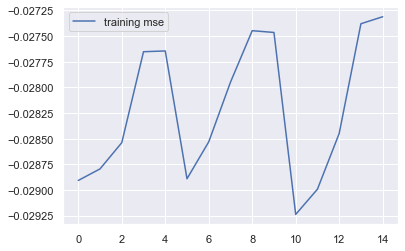

In [68]:
pdf = pd.DataFrame(all_training_scores['mean_train_score'], columns=['training mse'])
pdf.plot()

# Training R2

In [69]:
y_hat = search.predict(x_train)

r2_train = metrics.r2_score(y_train, y_hat)
print('R2 (training) = {}'.format(r2_train))


R2 (training) = 0.4053849845354104


In [70]:
# validation mean_absolute_percentage_error
train_error =  np.abs(y_train - y_hat)
mean_error = np.mean(train_error)
min_error = np.min(train_error)
max_error = np.max(train_error)
std_error = np.std(train_error)


print("Model Result (mean - std of error - min - max): %.2f (%.2f) %.2f %.2f MSE" \
      % (mean_error, std_error, min_error, max_error))

Model Result (mean - std of error - min - max): 0.10 (0.13) 0.00 0.90 MSE


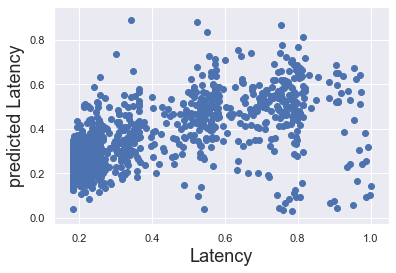

In [71]:
plt.scatter(y_train, y_hat)
plt.xlabel('Latency', size=18)
plt.ylabel("predicted Latency", size=18)
#plt.xlim(-2,3)
#plt.ylim(-3,1)
plt.show()

Text(0.5, 1.0, 'Residual PDF')

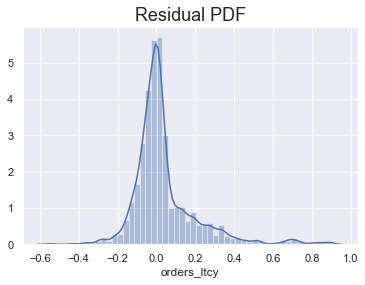

In [72]:
sns.distplot(y_train - y_hat)
plt.title('Residual PDF', size=18)

# Testing

In [73]:
y_hat_test = search.predict(x_test)

<function matplotlib.pyplot.show(*args, **kw)>

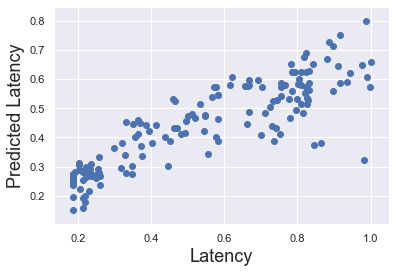

In [74]:
plt.scatter(y_test, y_hat_test)
plt.xlabel('Latency', size=18)
plt.ylabel('Predicted Latency', size=18)
plt.show

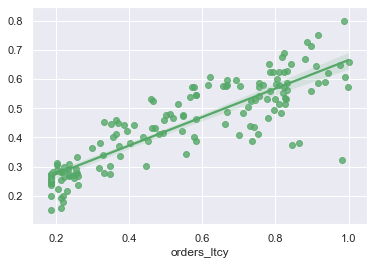

In [75]:
ax = sns.regplot(x=y_test, y=y_hat_test, color='g')

In [76]:
perf = pd.DataFrame(np.exp(y_hat_test), columns=['prediction'])
y_test = y_test.reset_index(drop=True)
perf['target'] = np.exp(y_test)
perf.head()

,prediction,target
0,1.28,1.20
1,1.32,1.25
2,1.31,1.27
3,1.31,1.28
4,1.30,1.28


In [77]:
# testing mean_absolute_percentage_error
perf['residual'] = perf['prediction'] - perf['target']
perf['difference%'] = np.absolute(perf['residual'] * 100 / perf['target'])
perf

,prediction,target,residual,difference%
0,1.28,1.20,0.07,6.15
1,1.32,1.25,0.08,6.27
2,1.31,1.27,0.05,3.65
3,1.31,1.28,0.03,2.25
4,1.30,1.28,0.02,1.21
...,...,...,...,...
145,1.80,2.13,-0.33,15.54
146,1.77,2.71,-0.94,34.60
147,2.12,2.50,-0.38,15.17
148,2.22,2.69,-0.46,17.25


In [78]:
perf.describe()

,prediction,target,residual,difference%
count,150.00,150.00,150.00,150.00
mean,1.57,1.79,-0.21,12.44
std,0.23,0.46,0.29,9.81
min,1.16,1.20,-1.29,0.01
25%,1.35,1.30,-0.41,4.16
50%,1.57,1.74,-0.10,8.58
75%,1.77,2.21,0.04,19.23
max,2.22,2.72,0.18,48.29


In [79]:
pd.options.display.max_rows = 999
pd.set_option('display.float_format', lambda x: '%.2f' % x)
perf.sort_values(by = ['difference%'])

,prediction,target,residual,difference%
118,1.77,1.77,0.00,0.01
72,1.45,1.45,-0.01,0.37
106,1.77,1.78,-0.01,0.52
6,1.31,1.30,0.01,0.75
33,1.40,1.39,0.01,1.06
27,1.22,1.20,0.01,1.12
39,1.24,1.26,-0.01,1.19
4,1.30,1.28,0.02,1.21
69,1.83,1.86,-0.02,1.33
21,1.25,1.23,0.02,1.58


# Prediction Accuracy

In [80]:
r2_test = metrics.r2_score(y_test, y_hat_test)
print('R2 (testing) = {}'.format(r2_test))

#also: R-Squared could obtain with
#pipe.score(x_test, y_test)

R2 (testing) = 0.49751405199091925


In [81]:
print(np.sqrt(mean_squared_error(y_test,y_hat_test)))

0.1831961900201056
